<a href="https://colab.research.google.com/github/sunnysavita10/Complete-LLM-Finetuning/blob/main/Knowledge_DIstillation_in_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step-by-step Explanation — Knowledge Distillation (Teacher → Student) on MNIST

Reference: [Distilling the Knowledge in a Neural Network (Hinton et al., 2015)](https://arxiv.org/pdf/1503.02531)

# Knowledge Distillation Explained 

This explains **Knowledge Distillation** — a way to train small, efficient models (students) by learning from big, powerful models (teachers).

---

## What is Knowledge Distillation?

Knowledge Distillation is a technique where a **small model (student)** learns from a **large, well-trained model (teacher)** to get similar accuracy but with less computational cost.

---

## Key Concepts

### 1. Ground Truth Labels (Hard Labels)

These are the **true answers** in your dataset. For example, if you show a picture of a dog, the label is “dog.”  
- The model learns to predict exactly this label.  
- Think of this like a teacher saying: *“This is definitely a dog.”*

### 2. Soft Output (Soft Labels)

The teacher model doesn’t just give one answer. Instead, it gives probabilities for **all possible classes**.  
For example, for a dog picture, the teacher might say:  
- Dog: 85%  
- Wolf: 10%  
- Fox: 5%

This gives a **softer**, more detailed understanding of the teacher’s belief.

### 3. Dark Knowledge

The “dark knowledge” is the **extra information hidden in the teacher’s soft output** — the relationships between classes.  
- For example, the teacher knows dogs and wolves are similar, so it assigns some probability to wolves.  
- This subtle information helps the student learn better than just using hard labels.

---

## How Knowledge Distillation Works

1. Train a **teacher model** on your dataset to get high accuracy.  
2. Use the teacher to generate **soft outputs** (probability distributions) for the training data.  
3. Train a smaller **student model** using a combination of:  
   - The teacher’s soft outputs (soft loss).  
   - The true labels from the dataset (hard loss).

---

## Why Use Knowledge Distillation?

- Smaller models are faster and require less memory — great for mobile or embedded devices.  
- Learning from soft outputs helps the student model understand nuanced class similarities, improving its accuracy.

---

## Simple Analogy

| Concept          | Analogy Example                     |
|------------------|-----------------------------------|
| Hard labels      | Teacher says: “This is a dog.”     |
| Soft output      | Teacher says: “85% dog, 10% wolf, 5% fox.” |
| Dark knowledge   | The teacher’s understanding of how animals are related |

---

# Step-by-step Explanation — Knowledge Distillation (Teacher → Student) on MNIST

Reference: [Distilling the Knowledge in a Neural Network (Hinton et al., 2015)](https://arxiv.org/pdf/1503.02531)

Below is a clear, ordered explanation of the workflow you pasted (MNIST, teacher/student MLPs, teacher training, distillation loop, result). Each step explains *what* happens and *why*.

---

## 1. Dataset load (MNIST)
- **What:** Load the MNIST dataset (images of digits 0–9).  
- **Preprocessing:**
  - Normalize pixel values (e.g. scale to [0,1] or mean/std normalization).
  - Flatten or keep as 2D depending on MLP vs. CNN (for a simple MLP flatten to 784-d vector).
  - Convert labels to integer class indices `0..9`.
- **Batches:** Create `DataLoader`/batches (e.g. `batch_size=64` or `128`) for efficient training.
- **Why:** Normalization stabilizes and speeds-up training; batching makes gradient updates practical.

---

## 2. Teacher & Student models
- **What (architectures in your example):**
  - **Teacher:** MLP with a larger hidden layer (e.g. 512 neurons). Higher capacity → typically better accuracy.
  - **Student:** Smaller MLP (e.g. 128 neurons). Faster inference, lower memory/compute, but less representational capacity.
- **Why two models:** Distillation transfers the teacher’s knowledge into a smaller model so the student becomes compact yet accurate.

---

## 3. Teacher training (supervised)
- **Train teacher normally:**
  - Loss: Cross-Entropy between teacher logits and ground-truth labels.
  - Optimizer: e.g. Adam or SGD, train until high accuracy on validation set.
- **Freeze the teacher:** After teacher is trained, stop updating its weights:
  - In code: `teacher.eval()` and `with torch.no_grad()` for forward passes, or set `requires_grad=False` and don’t call `optimizer.step()` for teacher.
- **Why:** Teacher must provide stable, high-quality soft targets for the student; we don't want teacher parameters to change during distillation.

---

## 4. Distillation (main training loop for the student)
For each mini-batch `(x, y)`:

1. **Forward pass through teacher (no grad):**
   - `logits_T = teacher(x).detach()`  
   - Compute *soft targets* by applying softmax with **temperature `T`**:
     \[
     p_T = \text{softmax}( \text{logits\_T} / T )
     \]
   - `T` > 1 makes the distribution softer (probabilities more spread out), exposing relative class similarities.

2. **Forward pass through student (trainable):**
   - `logits_S = student(x)`

3. **Compute soft (distillation) loss:**
   - Convert student outputs to a distribution at same temperature:
     \[
     q_S = \text{softmax}( \text{logits\_S} / T )
     \]
   - Use KL divergence (teacher → student) or cross-entropy between `p_T` and `q_S`:
     \[
     L_{\text{soft}} = \text{KL}(p_T \,||\, q_S)
     \]
   - Implementation note: many libraries expect `log` inputs, so you may use `KLDivLoss(log_q_S, p_T)`.

4. **Compute hard (label) loss:**
   - Standard cross-entropy between student logits and the ground-truth labels:
     \[
     L_{\text{hard}} = \text{CE}(\text{logits\_S}, y)
     \]

5. **Combine losses:**
   - Weighted sum:
     \[
     L = \alpha \cdot (T^2 \cdot L_{\text{soft}}) \;+\; (1-\alpha) \cdot L_{\text{hard}}
     \]
   - Common choices: `alpha ≈ 0.5`, `T ∈ [2, 5]`. The factor `T^2` compensates for the gradient scaling when using temperature (standard in Hinton et al.).

6. **Backprop & update student:**
   - `loss.backward()` then `optimizer.step()` for the student only.

7. **Repeat for all batches/epochs.**

**Why the soft targets?**  
The soft teacher distribution contains “dark knowledge”: information about inter-class similarities and relative probabilities that hard labels hide. This guides the student to better generalization.

---

## 5. Final result / Goal
- **What you get:** A *smaller student model* that often achieves accuracy close to the teacher while being much faster/smaller.
- **Why it works:** Student learns both:
  - the **hard labels** (ground truth),
  - and the **teacher’s soft behavior** (how strongly the teacher favors each class), which encodes richer structure about the task.

---

## 6. Important formulas (condensed)
- Teacher soft probabilities:
  \[
  p_T = \text{softmax}\left(\frac{z_T}{T}\right)
  \]
- Student soft probabilities:
  \[
  q_S = \text{softmax}\left(\frac{z_S}{T}\right)
  \]
- Distillation loss:
  \[
  L = \alpha \cdot T^2 \cdot \text{KL}(p_T \,||\, q_S) + (1-\alpha)\cdot \text{CE}(z_S, y)
  \]

---

## 7. Practical hyperparameters & tips
- **Batch size:** 64–256 typical.
- **Learning rates:** teacher might use `1e-3` (Adam) or `0.1` (SGD w/ momentum) depending on optimizer; student often similar but tuned separately.
- **Epochs:** teacher: train until strong accuracy (e.g. 10–30 on MNIST); student: 10–50 depending on data and size.
- **Temperature `T`:** common values `2`–`5` (higher → softer distributions). Try `T=2`, then tune.
- **Alpha:** start with `0.5`. If labels are reliable and teacher is very good, you can increase `alpha` to emphasize soft targets (or reduce it if hard labels are more important).
- **T² factor:** include it when using temperature in KL term to keep gradient magnitudes balanced.
- **Freeze teacher:** ensure teacher gradients are disabled (e.g., `.eval()` + `torch.no_grad()` or `param.requires_grad=False`).
- **Monitoring:** track student validation accuracy and both loss components (soft & hard) during training.

---

## 8. Small numeric illustration of temperature effect
- Suppose teacher logits for two classes are `[10, 2]`.
  - `T=1` → softmax ≈ `[0.9997, 0.0003]` (very peaked).
  - `T=5`: logits/5 → `[2, 0.4]` → softmax ≈ `[0.845, 0.155]` (much softer; student can learn that class 2 is somewhat plausible).
- **Interpretation:** Higher `T` reveals secondary preferences of the teacher — useful signals for the student.

---

## 9. Common pitfalls & debugging
- **Teacher too weak:** If teacher accuracy is poor, student can’t learn good priors. Make sure teacher is well-trained.
- **Forgetting `detach()` / freezing teacher:** If teacher grads are computed, you might accidentally update the teacher or increase memory use.
- **Mismatch in temperature scaling:** Forgetting to scale the KL loss by `T^2` can harm optimization.
- **Imbalanced `alpha`:** Too much weight on soft loss may ignore ground truth; too little and student won’t capture teacher's knowledge.
- **Leaking test data:** Don’t use test set in distillation (only training/validation).

---

## 10. Variants & extensions
- **Only soft targets:** Sometimes `alpha=1` (no hard labels) if teacher is perfect or dataset noisy.
- **Ensemble teacher:** Use ensemble of teachers to produce stronger soft targets.
- **Feature distillation:** Match intermediate representations (hints) between teacher and student (not just logits).
- **Online distillation:** Jointly train teacher and student (needs careful handling).
- **Temperature annealing:** Change `T` over time (e.g., start higher and lower it).

---

## Summary (one-liner)
Train a big teacher to high accuracy, freeze it, and train a smaller student to mimic both the teacher’s soft output distribution (soft targets at temperature `T`) and the ground-truth labels — combining them with a weighted loss so the student becomes small **and** accurate.

---

If you want, I can now:
- provide a short pseudocode of the training loop, or  
- give a ready-to-run PyTorch code snippet implementing this exact distillation (teacher+student + loss with `T^2` scaling), or  
- suggest specific hyperparameters for MNIST (exact `T`, `alpha`, lr, epochs, batch_size).
Which would you like next?


1. transforms.ToTensor()

MNIST images are originally in PIL Image format (28×28 grayscale).

This converts them into a PyTorch Tensor, and also scales pixel values to the [0,1] range.

Originally, pixel values are between 0–255.

After ToTensor(), each pixel becomes pixel / 255.

2. transforms.Normalize((0.5,), (0.5,))
This further shifts and scales pixel values to the [-1, 1] range.

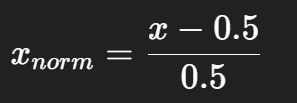
​

where x is the pixel value in [0,1] (after ToTensor()).

Meaning:

0 → -1

0.5 → 0

1 → +1

We normalize like this because:

Neural networks train better when inputs are centered around zero (mean ≈ 0).

It helps speed up training and prevents issues like exploding/vanishing gradients.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

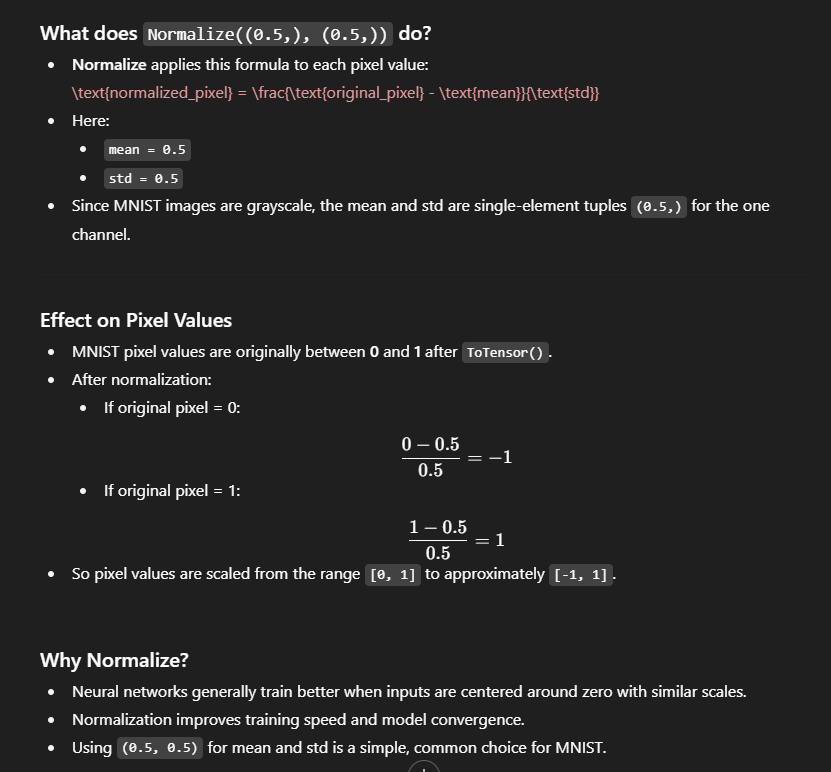

In [ ]:
# ----- Dataset (MNIST) -----
transform = transforms.Compose([
    transforms.ToTensor(), # converting normal tensor to pytorch tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize(mean = 0.5, std = 0.5) 
])

In [3]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]


In [4]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

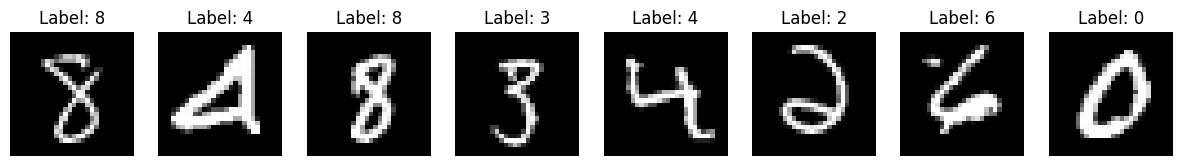

In [5]:
fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')  # grayscale
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.show()


# Teacher Model Summary

- **Model type:** Multi-Layer Perceptron (MLP)  
- **Purpose:** Classify MNIST digits (0–9)  
- **Input:** 28×28 grayscale image, flattened into a 784-dimensional vector  

---

## Architecture and Layers

- `nn.Flatten()`  
  - Converts 2D input image (28×28) into a 1D tensor of size 784.  
  - Necessary because linear layers expect flat vectors.

- `nn.Linear(28*28, 512)`  
  - Fully connected layer mapping 784 input features to 512 hidden units.

- `nn.ReLU()`  
  - Activation function adding non-linearity.

- `nn.Linear(512, 256)`  
  - Fully connected layer mapping 512 hidden units to 256 hidden units.

- `nn.ReLU()`  
  - Another ReLU activation.

- `nn.Linear(256, 10)`  
  - Final fully connected layer outputting 10 logits, corresponding to digit classes 0–9.

---

## Output

- The model outputs raw logits (unnormalized scores) for each class.  
- These logits are typically passed through a softmax during training or evaluation to get class probabilities.

---

## Notes

- The model is called the **teacher** because it is usually larger and better trained.  
- The teacher’s outputs guide the training of a smaller **student** model in knowledge distillation.


In [ ]:
import torch
import torch.nn as nn

# Define the Teacher Model as a Multi-Layer Perceptron (MLP)
class TeacherMLP(nn.Module):
    def __init__(self, hidden1=512, hidden2=256):
        super().__init__()
        # Sequential container to stack layers one after another
        self.net = nn.Sequential(
            nn.Flatten(),               # input layer: Flatten 28x28 image into a vector of size 784
            nn.Linear(28*28, hidden1), # hidden layer: First fully connected layer: input 784 → output 512
            nn.ReLU(),                 # Apply ReLU activation (introduces non-linearity)
            nn.Linear(hidden1, hidden2), # hidden layer: Second fully connected layer: 512 → 256
            nn.ReLU(),                 # Another ReLU activation
            nn.Linear(hidden2, 10)     # Final output layer: outputs 10 logits, one for each digit class
        )
        
    def forward(self, x):
        # Define forward pass: input tensor x goes through the layers sequentially
        return self.net(x)


In [28]:
# Create instances
teacher = TeacherMLP(hidden1=512, hidden2=256)

In [29]:
print(teacher)

TeacherMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


# Training Summary: `train_teacher`

- **Purpose:** Train the teacher model on labeled data.  
- **Inputs:**  
  - `model`: The neural network to train (teacher).  
  - `loader`: DataLoader providing batches of (input, label) pairs.  
  - `epochs`: Number of passes over the dataset (default: 1).  
  - `lr`: Learning rate for optimizer (default: 0.001).

---

## Key steps

- `optim.Adam(model.parameters(), lr=lr)`  
  - Initialize the Adam optimizer to update model parameters.  

- `nn.CrossEntropyLoss()`  
  - Define the loss function suitable for classification.

- `model.train()`  
  - Set the model to training mode (enables dropout, batch norm, etc.).

- For each epoch:  
  - For each batch in `loader`:
    - `opt.zero_grad()`  
      - Clear old gradients before backpropagation.  
    - `out = model(x)`  
      - Forward pass: compute model predictions (logits).  
    - `loss = loss_fn(out, y)`  
      - Calculate loss comparing predictions and true labels.  
    - `loss.backward()`  
      - Backpropagate to compute gradients.  
    - `opt.step()`  
      - Update model parameters based on gradients.  
    - Accumulate loss for monitoring progress.

---

## Output

- Prints average loss per epoch to track training progress:
  ```python
  print(f"Teacher Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")


In [ ]:
# Function to train the teacher model
def train_teacher(model, train_loader, epochs=1, lr=1e-3):
    
    # Create an Adam optimizer to update model parameters with the specified learning rate
    opt = optim.Adam(model.parameters(), lr=lr)
    
    # Define the loss function as Cross-Entropy Loss, suitable for classification
    loss_fn = nn.CrossEntropyLoss()
    
    # Set the model to training mode (enables dropout, batch norm if any)
    model.train()
    
    # Loop over the number of epochs
    for ep in range(epochs):
        total_loss = 0  # Initialize total loss for the epoch
        
        # Iterate over batches of data from the train_loader
        for x, y in train_loader:
            opt.zero_grad()       # Clear previous gradients
            
            out = model(x)        # Forward pass: compute model predictions (logits)
            
            loss = loss_fn(out, y) # Compute loss comparing predictions with true labels
            
            loss.backward()       # Backpropagation: compute gradients
            
            opt.step()            # Update model parameters using gradients
            
            total_loss += loss.item() # Accumulate loss for monitoring
        
        # Print average loss for the epoch
        print(f"Teacher Epoch {ep+1}: Loss = {total_loss/len(train_loader):.4f}")


In [31]:
train_teacher(teacher, train_loader)

Teacher Epoch 1: Loss = 0.3027


In [32]:
print(teacher.state_dict())  # Ye updated weights dikhayega


OrderedDict([('net.1.weight', tensor([[-0.0226,  0.0012, -0.0154,  ..., -0.0175, -0.0362, -0.0267],
        [-0.0119, -0.0141, -0.0230,  ...,  0.0003,  0.0189,  0.0281],
        [ 0.0184,  0.0174, -0.0294,  ...,  0.0196,  0.0083, -0.0079],
        ...,
        [ 0.0385,  0.0217,  0.0104,  ..., -0.0297, -0.0022,  0.0197],
        [-0.0067, -0.0302, -0.0067,  ..., -0.0211, -0.0273, -0.0380],
        [-0.0181, -0.0165, -0.0014,  ...,  0.0462,  0.0410, -0.0159]])), ('net.1.bias', tensor([ 0.0327,  0.0078,  0.0153,  0.0101, -0.0207,  0.0004, -0.0036, -0.0052,
        -0.0372, -0.0105, -0.0349, -0.0190, -0.0225,  0.0172,  0.0063, -0.0016,
        -0.0292, -0.0367,  0.0319,  0.0065, -0.0353, -0.0167, -0.0175, -0.0036,
        -0.0350, -0.0036, -0.0281,  0.0069,  0.0109,  0.0164, -0.0116,  0.0093,
         0.0014, -0.0309,  0.0250, -0.0049, -0.0204, -0.0078,  0.0299, -0.0253,
        -0.0145,  0.0215, -0.0091,  0.0277, -0.0342, -0.0293, -0.0042,  0.0091,
         0.0270,  0.0273, -0.0002, -0.0

In [ ]:
# # ----- Freeze Teacher ----- this is one of the way by freezing the teachr model and train student mode their is another way also without freezing like this.
# for param in teacher.parameters():
#     param.requires_grad = False
# teacher.eval()
# print("Teacher model trained and frozen.")

# Student Model Explanation (`StudentMLP`)

- **Purpose:** A smaller neural network with one hidden layer designed to learn from the teacher model.

---

## Architecture details:

- `nn.Flatten()`  
  - Flattens the 2D input image (28×28 pixels) into a 1D tensor of length 784 so it can be fed into linear layers.

- `nn.Linear(28*28, hidden)`  
  - Fully connected layer that maps the 784 input features to `hidden` neurons (default 128).

- `nn.ReLU()`  
  - Applies the ReLU activation function, introducing non-linearity to the network.

- `nn.Linear(hidden, 10)`  
  - Output layer mapping from hidden neurons to 10 logits, one for each MNIST digit class (0–9).

---

## Summary:

- The student model has fewer parameters than the teacher (only 1 hidden layer vs 2).  
- It is designed to be smaller and faster for efficient inference.  
- Learns to mimic the teacher’s behavior while using less compute.  
- The `forward` method simply passes input `x` through `self.net` (the sequence of layers).



In [ ]:
# ----- Student Model (1 hidden layer) -----
class StudentMLP(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        # Define the network as a sequence of layers:
        self.net = nn.Sequential(
            nn.Flatten(),                # Flatten 28x28 image into a 784-length vector
            nn.Linear(28*28, hidden),    # Fully connected layer with 'hidden' neurons (128 by default)
            nn.ReLU(),                   # ReLU activation adds non-linearity
            nn.Linear(hidden, 10)        # Output layer with 10 neurons (one per digit class)
            # This model is smaller than the teacher: only one hidden layer
        )

    def forward(self, x):
        # Forward pass through the network
        return self.net(x)


In [34]:
student = StudentMLP(hidden=128)

In [35]:
print(student)

StudentMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


# Pretrain Student Function Explanation (`pretrain_student`)

- **Purpose:** Optionally warm up the student model by training it on the true labels (hard labels) before distillation.

---

## Key components:

- `student.train()`  
  - Sets the student model to training mode (enables dropout, batch norm, etc.).

- `optim.Adam(student.parameters(), lr=lr)`  
  - Initializes the Adam optimizer for updating the student model parameters.

- `nn.CrossEntropyLoss()`  
  - Defines the loss function to measure difference between predicted logits and true labels.

---

## Training loop:

- For each epoch (`for ep in range(epochs):`):  
  - Loop over batches from `loader` providing `(x, y)` pairs (inputs and labels).
  
  - `opt.zero_grad()`  
    - Clears previous gradients before computing new ones.
  
  - `out = student(x)`  
    - Forward pass: compute student’s output logits for inputs `x`.
  
  - `loss = ce_loss(out, y)`  
    - Compute cross-entropy loss comparing student predictions with true labels `y`.
  
  - `loss.backward()`  
    - Backpropagate to calculate gradients of loss w.r.t. student parameters.
  
  - `opt.step()`  
    - Update student parameters based on gradients computed.

---

## Summary:

- This function trains the student model *only* on ground-truth labels (hard labels).  
- It helps the student learn a basic representation before the distillation process begins.  
- Useful as a warm-up but not mandatory — distillation usually improves on this baseline.


In [ ]:
# (A) Pretrain student on hard labels (optional warm-up)
def pretrain_student(student, loader, epochs=1, lr=1e-3):
    student.train()  # Set model to training mode (enables dropout, batch norm, etc.)
    
    opt = optim.Adam(student.parameters(), lr=lr)  # Initialize Adam optimizer
    
    ce_loss = nn.CrossEntropyLoss()  # Define cross-entropy loss function for classification
    
    for ep in range(epochs):  # Loop over epochs
        for x, y in loader:  # Loop over batches of data (inputs x and labels y)
            
            opt.zero_grad()  # Clear gradients from previous step
            
            out = student(x)  # Forward pass: compute student outputs (logits)
            
            loss = ce_loss(out, y)  # Compute loss between predictions and true labels
            
            loss.backward()  # Backpropagate to compute gradients
            
            opt.step()  # Update model parameters based on gradients

In [37]:
pretrain_student(student, train_loader, epochs=1)  # optional warm-up

In [38]:
# ----- Distillation Training -----
temperature = 2.0
alpha = 0.7
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(student.parameters(), lr=1e-3)

In [39]:
def distill(student, teacher, loader, epochs=1):
    for ep in range(epochs):

        student.train()

        total_loss = 0

        for x, y in loader:
            # Teacher outputs
            with torch.no_grad():
                t_logits = teacher(x)
                t_probs = torch.softmax(t_logits / temperature, dim=1)

            # Student outputs
            s_logits = student(x)
            s_log_probs = torch.log_softmax(s_logits / temperature, dim=1)

            # Losses
            loss_soft = kl_loss(s_log_probs, t_probs) * (temperature**2)
            loss_hard = ce_loss(s_logits, y)
            loss = alpha * loss_soft + (1 - alpha) * loss_hard

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            total_loss += loss.item()
        print(f"Student Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")

In [ ]:
# # (B) Then run your existing distill(...)
# distill(student, teacher, train_loader, epochs=3)

In [40]:
distill(student, teacher, train_loader)

Student Epoch 1: Loss = 0.1682


In [41]:
# ----- 5. Evaluation Function -----
def evaluate(model, loader, name="Model"):
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total * 100
    print(f"{name} Accuracy: {acc:.2f}%")
    return acc

In [42]:
# Evaluate both Teacher and Student
evaluate(teacher, test_loader, "Teacher")

Teacher Accuracy: 94.20%


94.19999999999999

In [43]:
evaluate(student, test_loader, "Student")

Student Accuracy: 94.21%


94.21000000000001

In [21]:
# ----- 6. Sample Predictions -----
def predict(model, x):
    model.eval()
    with torch.no_grad():
        out = model(x)
        return out.argmax(dim=1)

In [22]:
sample_batch, sample_labels = next(iter(test_loader))

In [23]:
preds = predict(student, sample_batch)

In [24]:
print("Sample predictions (Student):", preds[:20])

Sample predictions (Student): tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


In [25]:
print("True labels:", sample_labels[:20])

True labels: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


In [26]:
# ----- 7. Save Student Model -----
torch.save(student.state_dict(), "distilled_student.pth")
print("Student model saved as distilled_student.pth")

Student model saved as distilled_student.pth


### Classical LLM Distillation (BERT → DistilBERT)

| Block                   | Purpose (Hindi explain)                                                                                                        |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **0. Imports & Config** | Saare zaroori Python libraries import karo (Transformers, Torch, etc.), GPU/CPU detect karo, aur hyperparameters (batch size, lr, epochs, temperature, alpha) set karo. |
| **1. Dataset**          | Demo text dataset load karo, tokenizer se tokenize karo; Data collator automatic padding karega taaki batch uniform ho.      |
| **2. Models**           | Pretrained **BERT** ko teacher ke roop me load karo (freeze kar dena), aur **DistilBERT** ko student ke roop me load karo (trainable). |
| **3. Losses**           | Do losses use karo: <br>• **CE (CrossEntropy)** = hard labels ke liye <br>• **KL Divergence** = soft labels (teacher ke logits → softmax with temperature). |
| **4. Optimizer**        | **AdamW** optimizer use karo with **linear learning rate scheduler** training ke smooth control ke liye.                      |
| **5. distill_epoch()**  | Har batch pe: <br>• Teacher ke logits nikalo aur temperature ke saath soft targets banao <br>• Student ke logits nikalo <br>• Soft loss aur hard loss combine karo (α ke weight se) <br>• Sirf student ke parameters pe backprop karo. |
| **evaluate()**          | Validation set pe accuracy check karo taaki dekho student ka performance improve ho raha hai ya nahi.                        |
| **Loop**                | Har epoch ke liye: `distill_epoch()` run karo + `evaluate()` call karo.                                                       |
| **Save**                | Fine-tuned student model ko disk pe save kar do future inference ke liye.                                                     |

# Distillation: step-by-step (concise reference)

> **Tip:** For very large datasets or multi-GPU/TPU training use Hugging Face’s `DistillationTrainer` or `accelerate`. The core algorithm below stays the same.

---

## Overview (what’s happening)
1. Train a large **teacher** model (high capacity) normally and freeze it.  
2. Train a smaller **student** model to mimic the teacher **and** the ground-truth labels.  
3. Student loss = weighted combination of a **soft** (teacher) loss and a **hard** (label) loss.

---

## Step-by-step

### 1. Teacher output (`t_soft`)
- Compute teacher logits: `z_T = teacher(x)` (teacher is frozen; run under `torch.no_grad()`).
- Apply **temperature** `T` and softmax to get *soft targets*:
  \[
  p_T = \text{softmax}\!\left(\frac{z_T}{T}\right)
  \]
- `T > 1` “softens” the distribution (reveals class similarities).

### 2. Student output (`s_soft`)
- Compute student logits: `z_S = student(x)`.
- Convert to log-probabilities at the same temperature:
  \[
  \log q_S = \log\text{softmax}\!\left(\frac{z_S}{T}\right)
  \]

### 3. Distillation (soft) loss
- Use KL divergence (teacher distribution → student distribution).
- In PyTorch style: `nn.KLDivLoss(reduction='batchmean')(log_q_S, p_T)`
- Multiply the KL loss by `T^2` to correct gradient scale (Hinton et al.):
  \[
  L_{\text{soft}} = T^2 \cdot \text{KL}(p_T \,\|\, q_S)
  \]

### 4. Hard (label) loss
- Standard cross-entropy between student logits and true labels:
  \[
  L_{\text{hard}} = \text{CE}(z_S, y)
  \]

### 5. Combine
- Weighted sum:
  \[
  L = \alpha \cdot L_{\text{soft}} + (1-\alpha)\cdot L_{\text{hard}}
  \]
- Typical choices: `T ∈ [2,5]`, `α ≈ 0.5` (tune for your task).
- If `α = 1` → pure distillation (no hard labels). If `α = 0` → normal fine-tuning (no distillation).

---

## Implementation notes / best practices
- Freeze teacher: `teacher.eval()` and use `with torch.no_grad()` when generating `z_T`. This saves memory and avoids updating teacher weights.
- Use `F.softmax(z_T / T, dim=-1)` for teacher targets and `F.log_softmax(z_S / T, dim=-1)` for student input to `KLDivLoss`.
- In PyTorch, prefer `nn.KLDivLoss(reduction='batchmean')` for stable gradients.
- Multiply KL term by `T**2` (important — otherwise gradients from soft targets are scaled down).
- Monitor both components (`L_soft`, `L_hard`) and validation accuracy.

---

## Small numeric example (temperature effect)
- Teacher logits: `[10, 2]`
  - `T = 1` → `softmax([10,2]) ≈ [0.9997, 0.0003]` (very peaked)
  - `T = 2` → `softmax([5,1]) ≈ [0.982, 0.018]` (softer, reveals second choice)
  - `T = 5` → `softmax([2,0.4]) ≈ [0.83, 0.17]` (much softer)
- Softer distributions reveal the teacher’s relative beliefs and help the student learn nuanced class relations.

---

## Why distillation helps
- **Soft targets** encode “dark knowledge”: relative similarities between classes that hard labels hide.  
- Student learns both the dataset labels **and** the teacher’s nuanced behavior → better generalization for a much smaller model.

---

## Short pseudocode (conceptual)
1. `z_T = teacher(x)`  (no grad)
2. `p_T = softmax(z_T / T)`
3. `z_S = student(x)`
4. `log_q_S = log_softmax(z_S / T)`
5. `loss_soft = T^2 * KLDiv(log_q_S, p_T)`
6. `loss_hard = CrossEntropy(z_S, y)`
7. `loss = alpha * loss_soft + (1 - alpha) * loss_hard`
8. `loss.backward()` and `optimizer.step()` (update only student)

---

## Quick hyperparameter suggestions
- `T = 2` (good starting point), try `2–5`.  
- `alpha = 0.3–0.7` depending on trust in teacher vs labels.  
- `batch size`: 64–256 (task-dependent).  
- Ensure teacher has good accuracy before distillation.

---

## Final note
Distillation is **not** just fine-tuning: it explicitly transfers the teacher’s learned distributional knowledge (soft targets) into a compact student while still respecting hard labels. For large-scale runs, use `DistillationTrainer` / `accelerate` to scale cleanly across devices.


In [1]:
!pip install --upgrade datasets fsspec transformers

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader

In [4]:
batch_size   = 16
lr           = 5e-5
epochs       = 1
temperature  = 2.0
alpha_soft   = 0.5
max_len      = 128
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load dataset
raw = load_dataset("tweet_eval", "sentiment")

In [6]:
label_feature = raw["train"].features["label"]

In [7]:
print("Label names:", label_feature.names)

Label names: ['negative', 'neutral', 'positive']


In [8]:
# Subset (2.5k samples for train)
train = raw['train'].shuffle(seed=42).select(range(2500))

Why Train is Subset, but Val is Not

🔹 1. Training cost is high, validation cost is low

Training = multiple forward + backward passes → GPU heavy

Validation = only forward pass, no gradient update → fast

So it’s common to reduce training size for quick experiments but keep full validation for accurate metric evaluation.

🔹 2. Keeping val full improves generalization check

If you also reduce validation (e.g., from 872 → 100), metrics become noisy and unreliable.

Full validation gives stable accuracy/loss during training.

In [9]:
val   = raw['validation']

In [10]:
#Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, max_length=max_len)

In [12]:
# Tokenize & remove original text column
tokenized = {}

In [13]:
tokenized['train'] = train.map(tokenize, batched=True, remove_columns=['text'])
tokenized['validation'] = val.map(tokenize, batched=True, remove_columns=['text'])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
# Data Collator (auto-padding)
collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

In [15]:
# DataLoaders
train_dl = DataLoader(tokenized['train'], batch_size=batch_size,shuffle=True, collate_fn=collator)

In [16]:
val_dl = DataLoader(tokenized['validation'], batch_size=batch_size,shuffle=False, collate_fn=collator)

In [17]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [18]:
num_labels = 3

In [19]:
teacher = AutoModelForSequenceClassification.from_pretrained(
    "bert-large-uncased", num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
student = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Freeze teacher (no training)
for p in teacher.parameters():
    p.requires_grad = False
teacher.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [22]:
ce_loss = nn.CrossEntropyLoss()

In [23]:
kl_loss = nn.KLDivLoss(reduction="batchmean")

In [24]:
optimizer = optim.AdamW(student.parameters(), lr=lr)

In [25]:
from transformers import get_scheduler

In [26]:
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dl) * epochs,
)

In [27]:
from tqdm.auto import tqdm

In [28]:
def distill_epoch():
    student.train()
    pbar = tqdm(train_dl, desc="Train")
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention = batch["attention_mask"].to(device)
        labels    = batch["labels"].to(device)

        # Teacher predictions (soft targets)
        with torch.no_grad():
            t_logits = teacher(input_ids, attention_mask=attention).logits
            t_soft   = torch.softmax(t_logits / temperature, dim=1)

        # Student predictions
        s_logits = student(input_ids, attention_mask=attention).logits
        s_soft   = torch.log_softmax(s_logits / temperature, dim=1)

        # Distillation + CE Loss
        loss_soft = kl_loss(s_soft, t_soft) * (temperature ** 2)
        loss_hard = ce_loss(s_logits, labels)
        loss      = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

In [29]:
def evaluate():
    student.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in val_dl:
            ids  = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            lbl  = batch["labels"].to(device)
            out  = student(ids, attention_mask=attn).logits
            pred = out.argmax(dim=1)
            correct += (pred == lbl).sum().item()
            total   += lbl.size(0)
    return round(correct / total * 100, 2)

In [30]:
for ep in range(1, epochs + 1):
    distill_epoch()
    acc = evaluate()
    print(f"Epoch {ep}/{epochs} | Validation Accuracy: {acc}%")

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/1 | Validation Accuracy: 62.7%


In [31]:
# ---------- 6. Save Student ----------
student.save_pretrained("distilled_student_model")
tokenizer.save_pretrained("distilled_student_model")

('distilled_student_model/tokenizer_config.json',
 'distilled_student_model/special_tokens_map.json',
 'distilled_student_model/vocab.txt',
 'distilled_student_model/added_tokens.json',
 'distilled_student_model/tokenizer.json')

In [32]:
from sklearn.metrics import accuracy_score
import time

def predict_and_evaluate(model, name, test_dl):
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()

    with torch.no_grad():
        for batch in test_dl:
            ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            lbls = batch["labels"].to(device)

            logits = model(ids, attention_mask=attn).logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(lbls.cpu().tolist())

    total_time = time.time() - start_time
    acc = accuracy_score(all_labels, all_preds)
    avg_time = total_time / len(test_dl.dataset)

    print(f"\n {name}")
    print(f" Accuracy: {acc*100:.2f}%")
    print(f" Total Inference Time: {total_time:.2f} sec")
    print(f" Avg Time per Sample: {avg_time:.4f} sec")
    return acc, total_time, avg_time

In [33]:
# --------- Load test set ---------
test = load_dataset("tweet_eval", "sentiment", split="test[:500]")  # sample test
tokenized_test = test.map(tokenize, batched=True, remove_columns=["text"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dl = DataLoader(tokenized_test, batch_size=batch_size, shuffle=False, collate_fn=collator)

In [34]:
# --------- Compare Teacher vs Student ---------
predict_and_evaluate(teacher, name="TEACHER (BERT-Large)", test_dl=test_dl)
predict_and_evaluate(student, name="STUDENT (Distilled BERT)", test_dl=test_dl)



 TEACHER (BERT-Large)
 Accuracy: 22.00%
 Total Inference Time: 3.63 sec
 Avg Time per Sample: 0.0073 sec

 STUDENT (Distilled BERT)
 Accuracy: 60.80%
 Total Inference Time: 1.16 sec
 Avg Time per Sample: 0.0023 sec


(0.608, 1.1580901145935059, 0.0023161802291870115)

Backed by Research

📄 “Distilling Step-by-Step” (Google, ACL 2023)

A 770M T5 student outperformed PaLM-540B teacher on multiple tasks using rationale distillation.

📄 TinyBERT paper (Huawei, 2020)

Task-specific distillation allowed TinyBERT to beat BERT-base on SST-2 and MNLI.

| Reason                               | Explanation                                                            |
| ------------------------------------ | ---------------------------------------------------------------------- |
| **TweetEval = small, noisy data** | BERT-Large is overfitting or underconfident due to task size           |
| **Student is fine-tuned**         | You updated student weights on TweetEval task                          |
| **Teacher is frozen**             | You're using teacher just for soft logits, not re-finetuning           |
| **Teacher not task-specific**     | Your BERT-Large is general, but student is task-tuned via distillation |


| Model   | Accuracy | Speed | Comment                                                 |
| ------- | -------- | ----- | ------------------------------------------------------- |
| Teacher | 22%      | Slow  | Not tuned, generic, likely overfitting/underfitting     |
| Student | 60.8%    | Fast  | Task-specific distilled, learned from soft+hard targets |


## With LLM


Teacher (LLaMA‑2 7B) produces a probability distribution (next‑token probabilities) for each prompt.

Student (TinyLLaMA 1.1B) is trained to:

Mimic the teacher’s distribution (KLDivLoss → soft targets).

Be correct on the ground‑truth labels (CrossEntropyLoss → hard targets).

During each prompt, backpropagation updates only the Student’s weights.

As a result, the Student copies the Teacher’s reasoning behavior while being smaller and faster.

How is it run in practice?

The given snippet is just a mini example (3 prompts).

In real distillation:

Use millions of prompts (including synthetic ones).

Train in batches with Accelerate/DeepSpeed to manage GPU memory.

Precompute and store teacher outputs offline, then train the Student on those for a faster pipeline.

#### teacher_id = "meta-llama/Llama-2-7b-chat-hf"      # big model (teacher)
#### student_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"  # small model (student)

#### teacher_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
#### student_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [21]:
!pip install transformers accelerate bitsandbytes

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

In [23]:
teacher_id = "microsoft/phi-2"
student_id = "microsoft/phi-1_5"

In [24]:
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_id)
student_tokenizer = AutoTokenizer.from_pretrained(student_id)

In [25]:
if teacher_tokenizer.pad_token is None:
    teacher_tokenizer.pad_token = teacher_tokenizer.eos_token
if student_tokenizer.pad_token is None:
    student_tokenizer.pad_token = student_tokenizer.eos_token

In [26]:
teacher = AutoModelForCausalLM.from_pretrained(
    teacher_id,
    device_map="auto",
    load_in_8bit=True,
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
for p in teacher.parameters():
    print(p)

Parameter containing:
tensor([[ 1.6998e-02, -1.3275e-02,  2.0309e-02,  ...,  1.7822e-02,
          5.1346e-03, -7.7343e-04],
        [ 9.7351e-03,  5.1636e-02,  1.5656e-02,  ..., -6.7329e-03,
          6.9389e-03, -1.1322e-02],
        [-4.6387e-02, -9.0942e-03, -1.1349e-03,  ..., -3.0945e-02,
          3.8940e-02,  1.3847e-02],
        ...,
        [-5.9605e-08,  5.9605e-08, -5.9605e-08,  ...,  1.5140e-05,
         -1.1206e-05,  1.7762e-05],
        [-0.0000e+00, -5.9605e-08, -1.1921e-07,  ..., -2.5094e-05,
          3.7730e-05,  2.0683e-05],
        [ 0.0000e+00, -5.9605e-08,  5.9605e-08,  ..., -1.6034e-05,
         -1.5676e-05, -3.5882e-05]], device='cuda:0', dtype=torch.float16,
       requires_grad=True)
Parameter containing:
Parameter(Int8Params([[ 26,  -5, -23,  ..., -30,  15,  11],
            [-37, -16, -10,  ...,  15,   0, -26],
            [-22, -11,  -4,  ...,   0,   9,   9],
            ...,
            [-35, -26,   5,  ...,  20,  12,  34],
            [-37,  50,  -2,  ...

In [28]:
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

In [29]:
student = AutoModelForCausalLM.from_pretrained(
    student_id,
    device_map="auto",
    load_in_8bit=True,
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [30]:
prompts = [
    "Explain why the sky is blue. ### The sky appears blue because molecules in Earth's atmosphere scatter sunlight, and blue light is scattered more than other colors due to its shorter wavelength.",
    "What is the capital of France? ### The capital of France is Paris.",
    "Write a short story about a robot and a cat. ### Once upon a time, a lonely robot found a stray cat. They became best friends, exploring the city together, and the robot learned the meaning of companionship."
]


In [31]:
# ----- Distillation Hyperparams -----
temperature = 2.0
alpha_soft  = 0.7
ce_loss     = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
kl_loss     = nn.KLDivLoss(reduction="batchmean")
optimizer   = optim.AdamW(student.parameters(), lr=2e-5)

In [33]:
for prompt in prompts:
    # --- Tokenize separately ---
    t_inputs = teacher_tokenizer(prompt, return_tensors="pt", padding=True).to(teacher.device)
    s_inputs = student_tokenizer(prompt, return_tensors="pt", padding=True).to(student.device)

    with torch.no_grad():
        t_logits = teacher(**t_inputs).logits[:, :-1, :]
        t_soft = torch.softmax(t_logits / temperature, dim=-1)
        t_soft = torch.clamp(t_soft, min=1e-8)  # 🛠️ avoid log(0) in KLDiv

    s_logits = student(**s_inputs).logits[:, :-1, :]
    s_log_soft = torch.log_softmax(s_logits / temperature, dim=-1)

    labels = s_inputs["input_ids"][:, 1:].contiguous()

    loss_hard = ce_loss(s_logits.reshape(-1, s_logits.size(-1)), labels.reshape(-1))
    loss_soft = kl_loss(s_log_soft, t_soft) * (temperature ** 2)

    loss = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

    if torch.isnan(loss):
        print("⚠️ NaN detected on prompt:", prompt[:50])
        continue  # skip to next prompt

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Prompt: {prompt[:40]}..., Loss: {loss.item():.4f}")

Prompt: Explain why the sky is blue. ### The sky..., Loss: nan
Prompt: What is the capital of France? ### The c..., Loss: nan
Prompt: Write a short story about a robot and a ..., Loss: nan


In [ ]:
student.save_pretrained("distilled_phi1_5")
student_tokenizer.save_pretrained("distilled_phi1_5")
print("Distillation complete. Model saved in 'distilled_phi1_5/'")